# License Plate Recognition with OpenVINO

This notebook demonstrates license plate recognition with OpenVINO. We use the [License Plate Recognition Model](https://docs.openvino.ai/2020.2/_models_intel_license_plate_recognition_barrier_0001_description_license_plate_recognition_barrier_0001.html) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/). This model uses a small-footprint network trained end-to-end to recognize Chinese license plates in traffic.

License plate recognition model helps you get the chinese license plate number precisely in no time. The input of the color license plate image can be any size. It will be resized and augmented before put into the model. After matching the result to correct character, we can get the license plate number. In the notebook we show how to create the following pipeline:

![flowchart.png](https://user-images.githubusercontent.com/15709723/162659593-3f620d7a-44d2-4f49-a558-94c35a244a8e.png)

> Note: Augmentation method on image is optional and it may lead to the wrong recognition result. Thus, we recommend you to use it under special conditions like image overexposure or too dark.

Example image data comes from [CCPD (Chinese City Parking Dataset, ECCV)](https://github.com/detectRecog/CCPD)
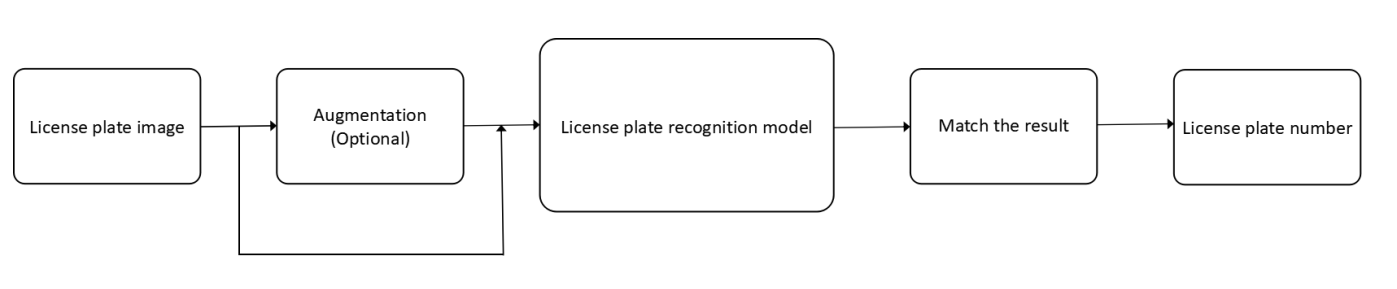

## Imports

In [1]:
import collections
import os
import sys
import time

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from openvino.runtime import Core

sys.path.append("../utils")
import notebook_utils as utils

## The Model

### Download the Model

We use `omz_downloader`, the tool from the `openvino-dev` package to download the selected model. It will be retrieved from the cache if the model is already downloaded.

In [2]:
# directory where model will be downloaded
base_model_dir = "model"

# model name as named in Open Model Zoo
model_name = "license-plate-recognition-barrier-0001"

# it will be retrieved from the cache if the model is already downloaded.
download_command = (
    f"omz_downloader "
    f"--name {model_name} "
    f"--output_dir {base_model_dir} "
    f"--cache_dir {base_model_dir}"
)

# this code is provided for the first download of the model
! $download_command

### Convert the Model

Since the pre-trained model is in Caffe format, we need to convert it into Intermediate Representation (IR). This step we use Model Converter (`omz_converter`), another tool from the `openvino-dev` package.

In [3]:
# "FP16", "FP32" or "FP16-INT8"
precision = "FP16"

# output path for the conversion
converted_model_path = f"model/intel/{model_name}/{precision}/{model_name}.xml"

# if the model has been already converted, this step is skipped.
if not os.path.exists(converted_model_path):
    convert_command = f"omz_converter " \
                      f"--name {model_name} " \
                      f"--download_dir {base_model_dir} " \
                      f"--precisions {precision}"
    
    # this code is provided for the first convert of the model
     ! $convert_command

### Load the Model

First, we create an Inference Engine. Then we read the network architecture and model weights from the .bin and .xml files to compile for the desired device. You can choose manually CPU, GPU, MYRIAD etc.

If you wnat OpenVINO to decide which hardware offers the best performance, you need to use `AUTO`.

In [4]:
# initialize inference engine
ie_core = Core()
# read the network and corresponding weights from file
model = ie_core.read_model(model=converted_model_path)
# compile the model for the CPU (you can choose manually CPU, GPU, MYRIAD etc.)
# or let the engine choose the best available device (AUTO)
compiled_model = ie_core.compile_model(model=model, device_name="CPU")

# get input and output nodes
input_layer = next(iter(compiled_model.inputs))
output_layer = next(iter(compiled_model.outputs))

# get input size
input_height, input_width = list(input_layer.shape)[2:4]

## Inference

### Using ImageLoader to Process Image


#### Model Limitations:
Only "blue" license plates, which are common in public, were tested thoroughly. Other types of license plates may underperform.


#### Model Input:

name: "data" , shape: [1x3x24x94] - An input image in following format [1xCxHxW]. Expected color order is BGR.

name: "seq_ind" , shape: [88,1] - An auxiliary blob that is needed for correct decoding. Set this to [0, 1, 1, ..., 1].

#### Notes:
Since the license plate image could be any size, we need to use ImageLoader to resize it to fit the model input requirements.
Augmentation method on image is optional and it may lead to the wrong recognition result. Thus, we recommend you to use it under special conditions like image overexposure or too dark.

In [5]:
def ShowImage(
    OriginImage: np.ndarray, InputImage: np.ndarray
) -> matplotlib.figure.Figure:
    """
    Visualise how the image we processed.

    Args:
        OriginImage (np.ndarray): Any size of color image.
        InputImage (np.ndarray): The input of the model before dimension transposed and expanded.

    Returns:
        Matplotlib figure.
    """
    figure, axis = plt.subplots(1, 2, figsize=(18, 9), squeeze=False)
    
    # adjust the image channels to the correct order.
    b,g,r = cv2.split(OriginImage)
    OriginImage = cv2.merge((r,g,b))
    axis[0, 0].imshow(OriginImage)
    axis[0, 0].set_title("OriginImage")
    
    # adjust the image channels to the correct order.
    b,g,r = cv2.split(InputImage)
    InputImage = cv2.merge((r,g,b))
    axis[0, 1].imshow(InputImage)
    axis[0, 1].set_title("InputImage")
    
    return figure


def ImageLoader(ImagePath: str, Augmentation: str = "None") -> np.ndarray:
    """
    Process the image if neccessary and then
    resize its shape to fit the input requirements.

    Args:
        ImagePath (string): Relative storage path of color image.
        Augmentation (string): Image augmentation method, if 'None', do nothing.
                    Including 'None', 'Laplace', 'Log', 'Gamma' and 'EquaHist'.

    Returns:
        input_img (np.ndarray): The input of the model. The dimension is 1x3x24x94.

    """
    ori_img = cv2.imread(ImagePath,1)

    # if gray image passed in, the programme will stop.
    assert len(ori_img.shape) == 3, "Failed to load image."
    print(f"Origin image shape: {ori_img.shape}")

    # if invalid augmentation method passed in, the programme will stop.
    assert Augmentation in [
        "None",
        "Laplace",
        "Log",
        "Gamma",
        "EquaHist",
    ], "Invalid Augmentation."

    if Augmentation == "None":
        img = ori_img

    elif Augmentation == "Laplace":
        kernel_sharpen = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        img = cv2.filter2D(ori_img, -1, kernel_sharpen)

    elif Augmentation == "Log":
        img = 42 * np.log(1.0 + ori_img)
        img = np.uint8(img + 0.5)

    elif Augmentation == "Gamma":
        lut = np.zeros(256, dtype=np.float32)
        for i in range(256):
            lut[i] = 0.00000005 * i**4.0
        img = cv2.LUT(ori_img, lut)
        img = np.uint8(img + 0.5)

    elif Augmentation == "EquaHist":
        img0 = cv2.equalizeHist(ori_img[:, :, 0])
        img1 = cv2.equalizeHist(ori_img[:, :, 1])
        img2 = cv2.equalizeHist(ori_img[:, :, 2])

        img = cv2.merge([img0, img1, img2])

    # resize its shape to fit the model input requirements.
    resized_img = cv2.resize(img, (input_width, input_height))

    # visualise how the image we process.
    ShowImage(ori_img, resized_img)
    trans_img = resized_img.transpose(2, 0, 1)
    input_img = np.expand_dims(trans_img, axis=0)
    return input_img

### Do the Inference
Match the output array into correct recognition results
Run license plate recognition model with the input and then match the result.

#### Process the Image

Origin image shape: (96, 181, 3)


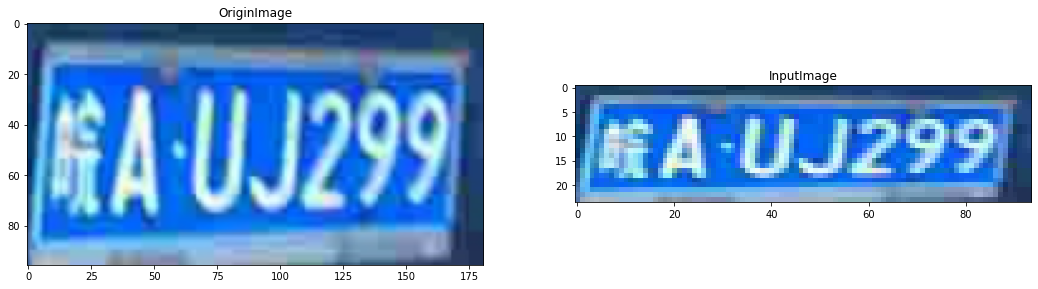

In [6]:
input_img = ImageLoader(ImagePath = "data/example.png", Augmentation = "None")

#### Input the Data and Get the Result

In [7]:
result = compiled_model([input_img])[output_layer]

#### Match the Output Array into Correct Recognition Results

In [8]:
def result_to_string(result: np.ndarray) -> str:
    """
    Match the output array into correct recognition results.

    Args:
        result (np.ndarray): The output of the model. The dimension is 1x88x1x1.

    Returns:
        str: The license plate recognition results.
    """
    match_dictionary = [
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
        "<Anhui>",
        "<Beijing>",
        "<Chongqing>",
        "<Fujian>",
        "<Gansu>",
        "<Guangdong>",
        "<Guangxi>",
        "<Guizhou>",
        "<Hainan>",
        "<Hebei>",
        "<Heilongjiang>",
        "<Henan>",
        "<HongKong>",
        "<Hubei>",
        "<Hunan>",
        "<InnerMongolia>",
        "<Jiangsu>",
        "<Jiangxi>",
        "<Jilin>",
        "<Liaoning>",
        "<Macau>",
        "<Ningxia>",
        "<Qinghai>",
        "<Shaanxi>",
        "<Shandong>",
        "<Shanghai>",
        "<Shanxi>",
        "<Sichuan>",
        "<Tianjin>",
        "<Tibet>",
        "<Xinjiang>",
        "<Yunnan>",
        "<Zhejiang>",
        "<police>",
        "A",
        "B",
        "C",
        "D",
        "E",
        "F",
        "G",
        "H",
        "I",
        "J",
        "K",
        "L",
        "M",
        "N",
        "O",
        "P",
        "Q",
        "R",
        "S",
        "T",
        "U",
        "V",
        "W",
        "X",
        "Y",
        "Z",
    ]
    str_list = list()
    for iter in range(88):
        if result[0][iter][0][0] != -1:
            str_list.append(match_dictionary[int(result[0][iter][0][0])])
        else:
            break
    ans = "".join(str_list)
    return ans

#### Print out the result

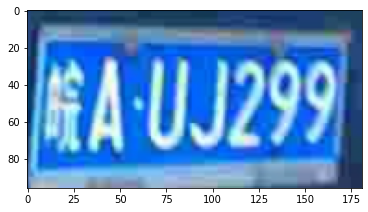

In [9]:
# get the result.
plate_recognition = result_to_string(result)

# print out the match result if necessary.
print(f"The license plate recognition result is: {plate_recognition}")

# compare to the origin image.
compare = cv2.imread("data/example.png")

# adjust the image channels to the correct order.
b,g,r = cv2.split(compare)
compare = cv2.merge((r,g,b))
plt.imshow(compare)
plt.show()

## References

1. [License Plate Recognition Model](https://docs.openvino.ai/2020.2/_models_intel_license_plate_recognition_barrier_0001_description_license_plate_recognition_barrier_0001.html)
2. [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/)
3. [403-action-recognition-webcam](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/403-action-recognition-webcam/403-action-recognition-webcam.ipynb)